# Rosenblatt Perceptron

In this notebook I try to implement the Rosenblatt Perceptron in plain numpy. The foundation research paper you will find here: https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf 

The perceptron is described in four steps. I will iterate through the steps and develop the code step by step.



![Fig 1. Organization of a perceptron](https://www.researchgate.net/publication/328966158/figure/fig1/AS:693278764707841@1542301946487/The-original-perceptron-concept-from-Rosenblatt-ref-7-public-domain-artificial.png)  
FIG. 1. Organization of a perceptron.

**Perceptron forward pass**

1. Transofrm the signal
   - Stimulis on a retina are captured as a *all or nothing signal* which I interpret as a binary signal. In the example here we transform some numbers of the mnist dataset into this form of a signal.
   - This signal has random connections to the associatioin matrix (weights); (I implemented this as a matrix multiplication with random binary values on the diagonal)
2. multiply the signal with the weights
3. add bias
4. apply the activation function


**Perceptron Learning Rule**  

1. Get the perceptron prediction (forwardpass)
2. Compute the error, i.e. the difference between the prediction and the target
3. Multiply each input value by the error (and the learning rate) and add it to the weight (backwardpass)
4. Add the error to the bias


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

from src.helpers.load_data import mnist
from src.helpers.plot import plot_examples

%config InlineBackend.figure_format='retina'

train_images, train_labels, test_images, test_labels = mnist()

Dataset MNIST
    Number of datapoints     
    Train:  60000
    Test:   10000
    Source: https://ossci-datasets.s3.amazonaws.com/mnist/



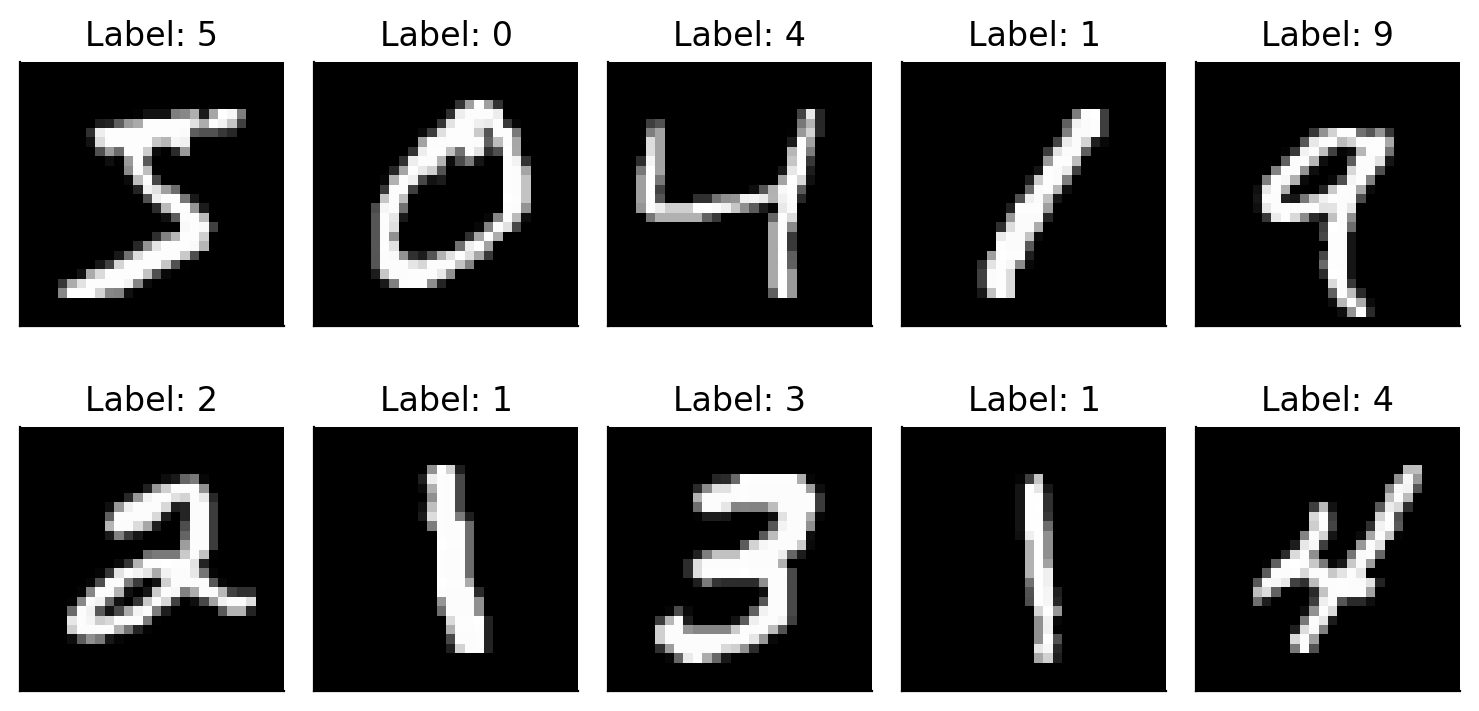

In [26]:
# inspect image data as it is
plot_examples(train_images, train_labels)

Above we see the grayscale of the numeric pixel values the digital images are consisting of.


In [27]:
# first we implement the perceptron as a binary classifier to classify the digit 0 and 1

binary_compare_labels = [4, 9]
idx2label = dict(enumerate(binary_compare_labels))
label2idx = {label: i for i, label in idx2label.items()}
binary_index = np.isin(train_labels, binary_compare_labels)
binary_train_labels = train_labels[binary_index]
binary_train_images = train_images[binary_index]

In [28]:
# Normalize the data first between 0 and 1


def normalize(
    X: np.ndarray[np.ndarray[np.ndarray[np.float32]]], x_min: float, x_max: float
) -> np.ndarray[np.ndarray[np.ndarray[np.float32]]]:
    """norm normalizes the values of the input arrays between x_min and x_max.

    Args:
        X (np.ndarray): image data as np.ndarrays
        x_min (float): min value of the transformed input array
        x_max (float): max value of the transformed input array

    Returns:
        np.ndarray: transformed input array
    """

    nom = (X - X.min(axis=0)) * (x_max - x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom == 0] = 1
    return x_min + nom / denom

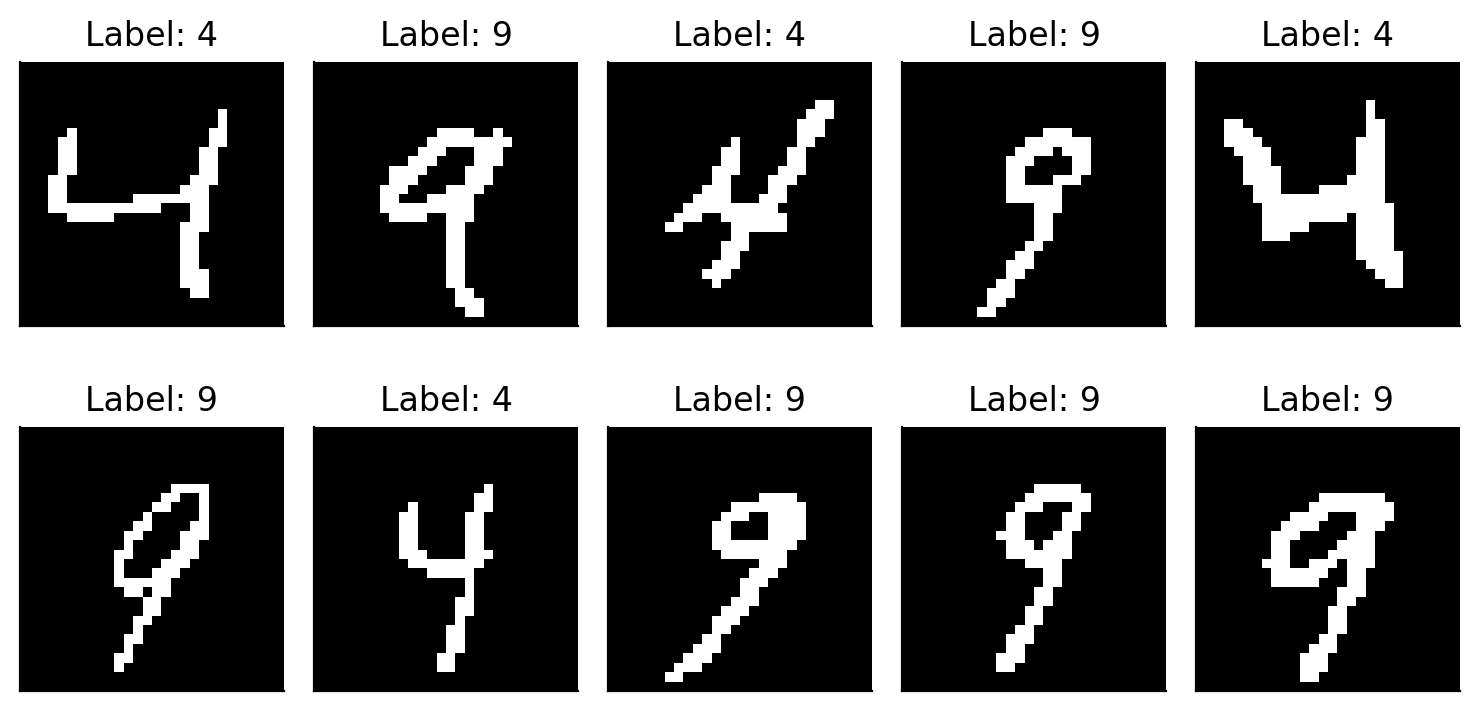

In [29]:
# inspect several transformed images, normalized between 0 and 1 and then rounded to a integer.
plot_examples(normalize(binary_train_images, 0, 1).round(decimals=0), binary_train_labels)

The plot obove shows the images converted to a binary signal. This signal is then used as input to the perceptron.

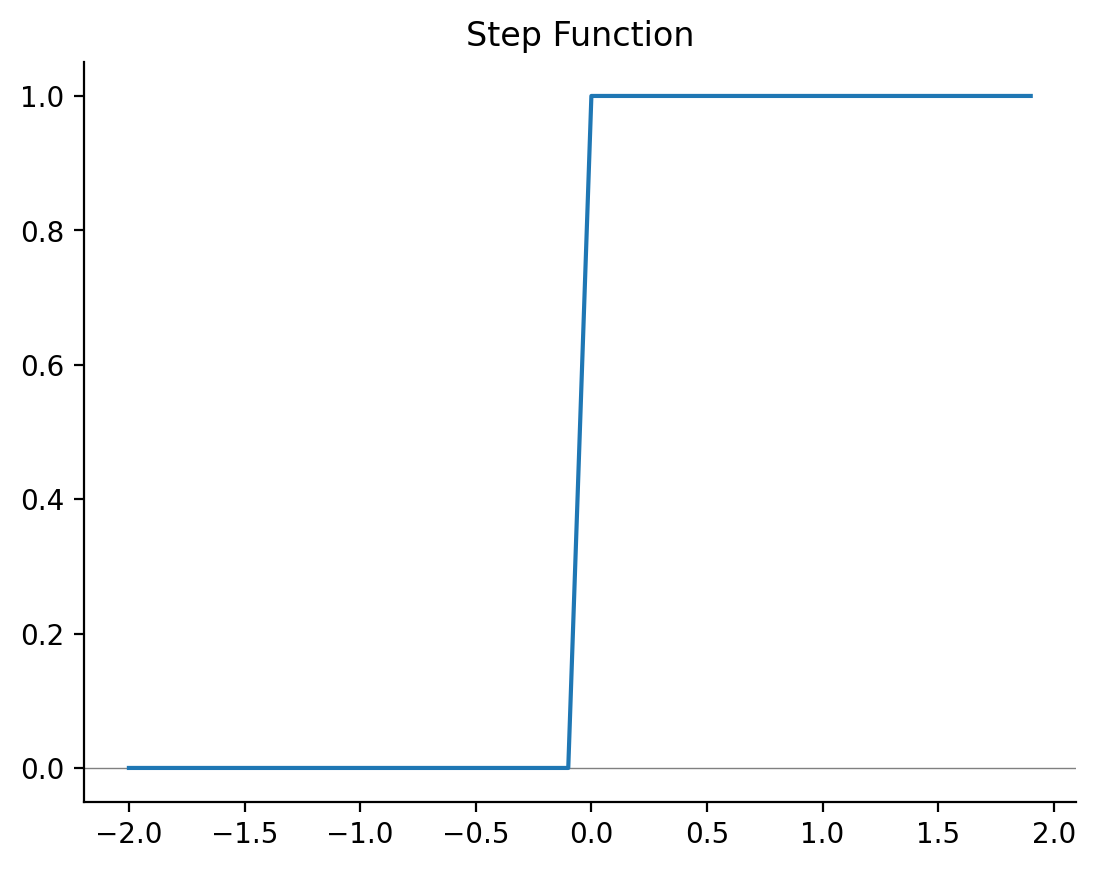

In [30]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# activation function is the step function


def step_function(x: np.ndarray) -> np.ndarray:
    """step_function applies the step activation function to the input array.

    Args:
        x (np.ndarray): input array

    Returns:
        np.ndarray: transformed input array
    """
    return np.where(x > 0, 1, 0)


# inspect the step activation function
input = np.arange(-2.0, 2.0, 0.1)

plt.axhline(0, color="gray", linewidth=0.5)
plt.plot(input, step_function(input))
plt.title("Step Function")
plt.show()

In [31]:
# Forward pass of a single-layer neural network

w_len = binary_train_images[0].flatten().shape[0]
bias_size = 1

weights = np.zeros(w_len + bias_size)

def predict(transformed_image:np.ndarray, weights:np.ndarray, bias_size:int=1, backward=False):
    """
    Perform a forward pass through the neural network.
    
    Parameters:
    transformed_image (np.ndarray): The input image after transformation.
    weights (np.ndarray): The weights of the neural network.
    bias_size (int): The size of the bias term.
    backward (bool): If True, return idx otherwise return the label.
    
    Returns:
    np.ndarray: The prediction made by the neural network.
    """
    # apply random conections from the input to the assosciated weights

    


    # Calculate the weighted sum of inputs and weights
    weighted_sum = np.matmul(transformed_image, weights[:-bias_size]) + weights[-bias_size]
    
    # Apply the activation function 
    prediction = step_function(weighted_sum)
    
    # Return the prediction
    if backward:
        return prediction
    else:
       return idx2label.get(prediction.item())


#transform the image
transformed_image = normalize(binary_train_images[0], 0, 1).round(decimals=0).flatten()
predicted_value = predict(transformed_image, weights)
print(predicted_value)


4


In [32]:
#backward pass

def backward_pass(transformed_image:np.ndarray, label:np.ndarray, weights:np.ndarray, learning_rate:float=0.01, bias_size:int=1) -> Tuple[np.ndarray, float]:
    """
    Perform a backward pass through the neural network.
    
    Parameters:
    transformed_image (np.ndarray): The input image after transformation.
    label (np.ndarray): The true label of the image.
    weights (np.ndarray): The weights of the neural network.
    learning_rate (float): The learning rate for weight updates.
    bias_size (int): The size of the bias term.
    
    Returns:
    Tuple[np.ndarray, float]: Updated weights and the error.
    """
    
    # Forward pass
    prediction = predict(transformed_image, weights, bias_size, backward=True)
    
    # Calculate the error
    error = label2idx.get(label) - prediction

    # Update weights and bias
    weights[:-bias_size] += learning_rate * error * transformed_image
    weights[-bias_size] += learning_rate * error
    
    return weights, abs(error)

# Example usage
new_weights, loss = backward_pass(transformed_image, binary_train_labels[0], weights, learning_rate=0.1, bias_size=1)

# Print the updated weights in the same shape as the image
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(new_weights[:-bias_size].reshape(28, -1))

print(weights.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [33]:
random_weight = np.diag(np.random.rand(w_len).round(decimals=0))
random_weight

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(784, 784))

In [34]:
# define the training loop


def train(
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 100,
    learning_rate: float = 0.1,
    bias_size: int = 1,
) -> np.ndarray:
    """train trains the perceptron using the training data.

    Args:
        X_train (np.ndarray): training data
        y_train (np.ndarray): training labels
        epochs (int, optional): number of epochs. Defaults to 100.
        learning_rate (float, optional): learning rate. Defaults to 0.1.

    Returns:
        np.ndarray: weights
    """

    # initialize weights
    w_len = X_train[0].flatten().shape[0]
    weights = np.zeros(w_len + bias_size)
    random_weight = np.diag(np.random.rand(w_len).round(decimals=0))
    # iterate over the epochs
    train_metrics = dict()
    for epoch in range(epochs):
        # iterate over the training data
        epoch_loss = 0
        for image, label in zip(X_train, y_train):
            # transform the image to a binary vector
            transformed_image = normalize(image, 0, 1).round(decimals=0).flatten()
            transformed_image = np.dot(transformed_image, random_weight)
            weights, loss = backward_pass(
                transformed_image,
                label=label,
                weights=weights,
                learning_rate=learning_rate,
                bias_size=bias_size,
            )
            epoch_loss += loss
        # as we use only binary values of 0 and 1, the loss is the number of misclassified images
        # we can calculate the accuracy as well
        train_metrics[epoch] = {
            "loss": epoch_loss,
            "accuracy": (len(y_train) - epoch_loss) / len(y_train),
        }
        print(
            f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {train_metrics[epoch]['accuracy']:.4f}"
        )
    return weights, random_weight


# train the perceptron
weights, random_weight = train(
    binary_train_images, binary_train_labels, epochs=10, learning_rate=0.1, bias_size=1
)

Epoch 0: Loss: 1034.0000, Accuracy: 0.9123
Epoch 1: Loss: 888.0000, Accuracy: 0.9247
Epoch 2: Loss: 809.0000, Accuracy: 0.9314
Epoch 3: Loss: 798.0000, Accuracy: 0.9323
Epoch 4: Loss: 799.0000, Accuracy: 0.9322
Epoch 5: Loss: 814.0000, Accuracy: 0.9310
Epoch 6: Loss: 764.0000, Accuracy: 0.9352
Epoch 7: Loss: 783.0000, Accuracy: 0.9336
Epoch 8: Loss: 748.0000, Accuracy: 0.9366
Epoch 9: Loss: 782.0000, Accuracy: 0.9337


In [35]:
binary_index = np.isin(test_labels, binary_compare_labels)
binary_test_labels = test_labels[binary_index]
binary_test_images = test_images[binary_index]

In [36]:
def eval(
    X_test: np.ndarray,
    y_test: np.ndarray,
    weights: np.ndarray,
    random_weight: np.ndarray,
    bias_size: int = 1,
    multiclass: bool = False,
) -> tuple:
    """eval evaluates the perceptron using the test data.

    Args:
        X_test (np.ndarray): test data
        y_test (np.ndarray): test labels
        weights (np.ndarray): weights
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        tuple: accuracy and predictions
    """

    # initialize predictions
    predictions = np.zeros(X_test.shape[0])

    # iterate over the test data
    for i, image in enumerate(X_test):
        if multiclass:
            transformed_image = normalize(image, 0, 1).flatten()
        else:
            transformed_image = normalize(image, 0, 1).round(decimals=0).flatten()
            transformed_image = np.dot(transformed_image, random_weight)
        prediction = predict(transformed_image, weights, bias_size)
        predictions[i] = prediction

    # calculate accuracy
    accuracy = np.sum(predictions == y_test) / len(y_test)

    return accuracy, predictions


# evaluate the perceptron
accuracy, predictions = eval(
    binary_test_images, binary_test_labels, weights, random_weight, bias_size=1
)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


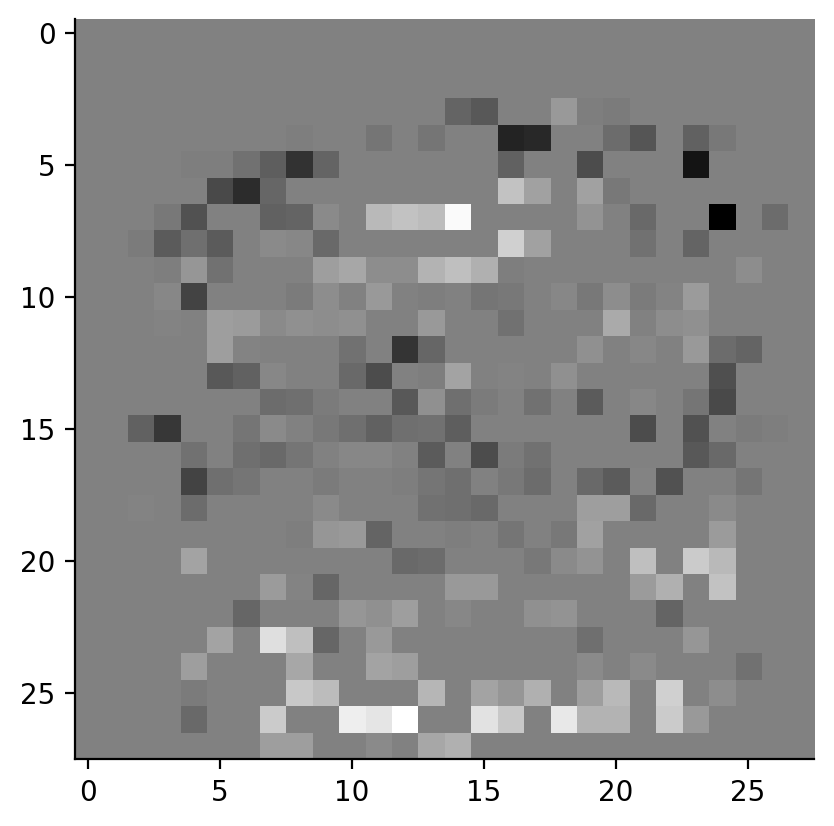

In [37]:
plt.imshow(weights[:-1].reshape(28, 28), cmap="gray")

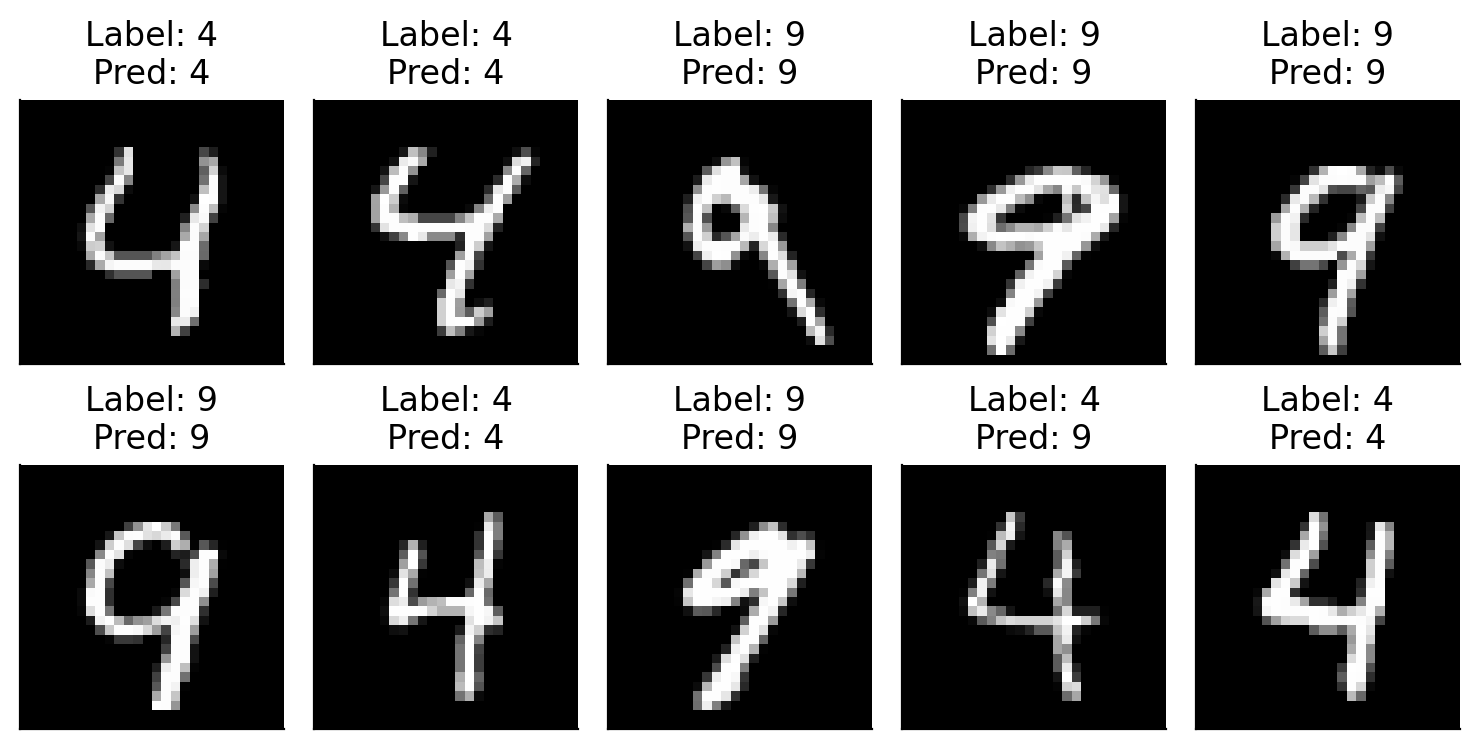

In [38]:
plot_examples(
    binary_test_images[:10],
    labels=binary_test_labels[:10],
    predictions=[
        predict(normalize(image, 0, 1).round().flatten(), weights, bias_size=1)
        for image in binary_test_images[:10]
    ],
)

## Multiclass Perceptron on MNIST

Now we can implement the perceptron as a multi-class classifier to classify all digits from 0 to 9. We can use the same training logic as before, but we need to change the calculation of the metrics as well as the dimensions of the weights and biases. At least I change the binary step function to a argmax function to get the prediction with the highest probability.

In [39]:
# initialize the weights

w_len = train_images[0].flatten().shape[0]
bias_size = 1
n_classes = np.unique(train_labels).shape[0]

weights = np.zeros((n_classes, w_len + bias_size))
weights[0].shape

(785,)

In [40]:
def predict(
    transformed_image: np.ndarray, weights: np.ndarray, bias_size: int = 1
) -> int:
    """predict predicts the label of the input image using the weights.

    Args:
        transformed_image (np.ndarray): transformed image
        weights (np.ndarray): weights
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        int: predicted label
    """
    # initialize predictions
    preds = np.zeros(n_classes)

    # iterate over the classes
    for i in range(n_classes):
        # calculate the weighted sum of inputs and weights
        weighted_sum = (
            np.dot(weights[i][:-bias_size], transformed_image) + weights[i][-bias_size]
        )
        preds[i] = weighted_sum

    return np.argmax(preds)


transformed_image = normalize(train_images[0], 0, 1).round(decimals=0).flatten()
predicted_value = predict(transformed_image, weights)
print(predicted_value)

0


In [41]:
# backward pass
def backward_pass(
    transformed_image: np.ndarray,
    label: np.ndarray,
    weights: np.ndarray,
    learning_rate: float = 0.1,
    bias_size: int = 1,
) -> Tuple[np.ndarray, float]:
    """backward_pass updates the weights using the perceptron learning rule.

    Args:
        transformed_image (np.ndarray): transformed image
        label (np.ndarray): label
        weights (np.ndarray): weights
        learning_rate (float, optional): learning rate. Defaults to 0.1.
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        tuple: updated weights and loss
    """
    # calculate the prediction
    prediction = predict(transformed_image, weights, bias_size)

    # calculate the loss
    loss = 0
    if prediction != label:
        loss = 1

        # update the weights
        # first decrease the weights for the misclassified class as the error is 1, we don't need to multiply with the error
        weights[prediction][:-bias_size] -= learning_rate * transformed_image
        weights[prediction][-bias_size] -= learning_rate
        # then increase the weights for the correct class
        weights[label][:-bias_size] += learning_rate * transformed_image
        weights[label][-bias_size] += learning_rate

    return weights, loss


# Example usage
new_weights, loss = backward_pass(
    transformed_image, train_labels[0], weights, learning_rate=0.1, bias_size=1
)

# Print the updated weights in the same shape as the image
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(new_weights[0][:-bias_size].reshape(28, -1))

print(weights.shape)

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1  0.  -0.1 -0.1 -0.1 -0.1  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1  0.   0.   0.   0. ]

The perceptron predicted zero while the actual class was a five. Therefore the weights are in such way updated, that false positives of fives are punished, wich is visible in the visual representation of the first weight. Lets have a look at the fifth weight. Guess how it looks ;-)

In [42]:
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(new_weights[5][:-bias_size].reshape(28, -1))

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.1 0.1 0.1 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.

yes! here we see that the weights for the correct class (5) are increased. Which illustrates how the backward pass works.

In [43]:
# Let's implement the training loop for all classes


def train(
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 100,
    learning_rate: float = 0.1,
    bias_size: int = 1,
) -> np.ndarray:
    """train trains the perceptron using the training data.

    Args:
        X_train (np.ndarray): training data
        y_train (np.ndarray): training labels
        epochs (int, optional): number of epochs. Defaults to 100.
        learning_rate (float, optional): learning rate. Defaults to 0.1.
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        np.ndarray: weights
    """
    # initialize weights
    w_len = train_images[0].flatten().shape[0]
    n_classes = np.unique(train_labels).shape[0]
    weights = np.zeros((n_classes, w_len + bias_size))
    # random_weight = np.diag(np.random.rand(w_len).round(decimals=0))

    # iterate over the epochs
    train_metrics = dict()
    for epoch in range(epochs):
        # iterate over the training data
        epoch_loss = 0
        for image, label in zip(X_train, y_train):
            # transform the image to a binary vector
            transformed_image = norm(
                image, 0, 1
            ).flatten()  # .round(decimals=0).flatten()
            # transformed_image = np.dot(transformed_image, random_weight)
            weights, loss = backward_pass(
                transformed_image,
                label=label,
                weights=weights,
                learning_rate=learning_rate,
                bias_size=bias_size,
            )
            epoch_loss += loss
        # as we use only binary values of 0 and 1, the loss is the number of misclassified images
        # we can calculate the accuracy as well
        train_metrics[epoch] = {
            "loss": epoch_loss,
            "accuracy": (len(y_train) - epoch_loss) / len(y_train),
        }
        print(
            f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {train_metrics[epoch]['accuracy']:.4f}"
        )
    return weights, random_weight


# train the perceptron
weights, random_weight = train(
    train_images, train_labels, epochs=10, learning_rate=0.01, bias_size=1
)

Epoch 0: Loss: 8525.0000, Accuracy: 0.8579
Epoch 1: Loss: 7092.0000, Accuracy: 0.8818
Epoch 2: Loss: 6815.0000, Accuracy: 0.8864
Epoch 3: Loss: 6773.0000, Accuracy: 0.8871
Epoch 4: Loss: 6621.0000, Accuracy: 0.8897
Epoch 5: Loss: 6561.0000, Accuracy: 0.8907
Epoch 6: Loss: 6439.0000, Accuracy: 0.8927
Epoch 7: Loss: 6506.0000, Accuracy: 0.8916
Epoch 8: Loss: 6406.0000, Accuracy: 0.8932
Epoch 9: Loss: 6395.0000, Accuracy: 0.8934


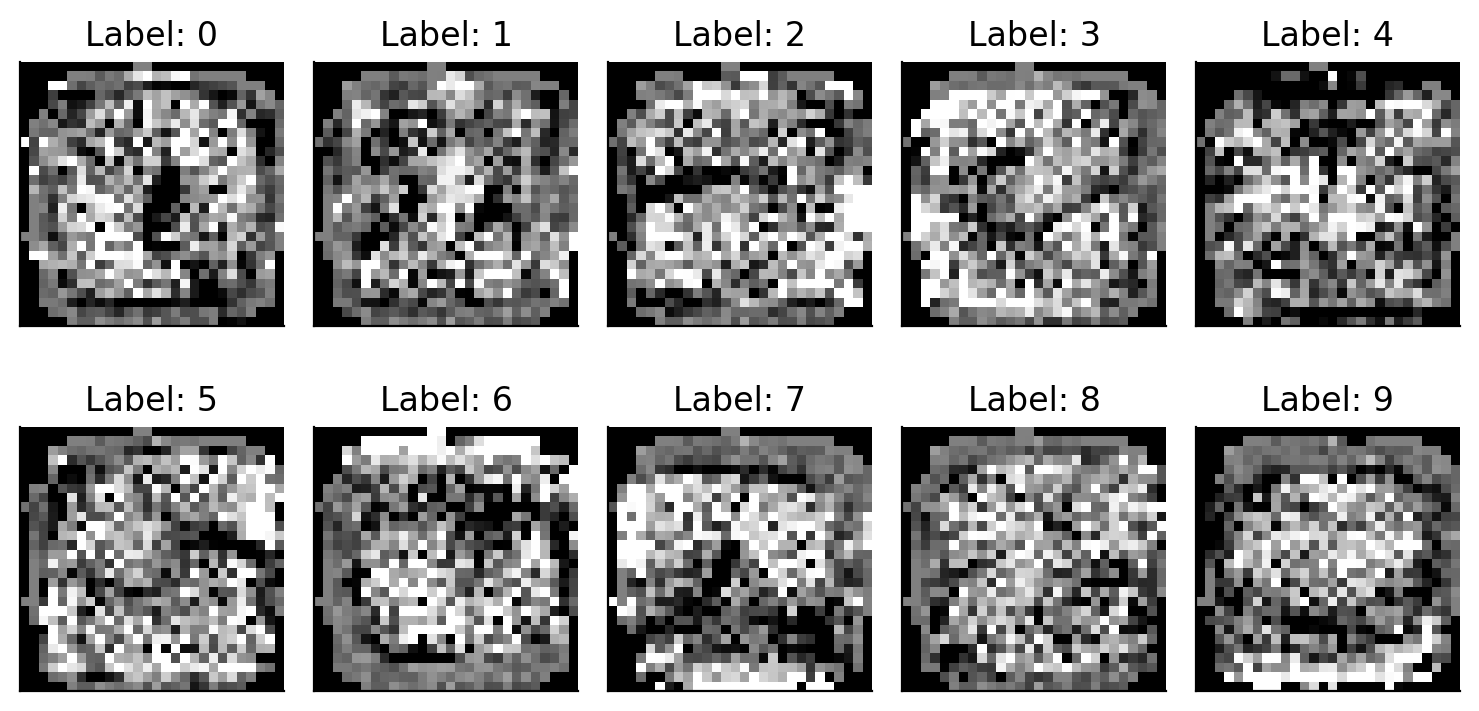

In [44]:
# Let's inspect the weights / latent space of the perceptron for each class
# we can visualize the weights as images

plot_examples(
    [weight[:-bias_size].reshape(28, -1) for weight in norm(weights, 0, 1)],
    labels=np.arange(10),
)

In [45]:
accuracy, predictions = eval(
    test_images, test_labels, weights, random_weight, bias_size=1, multiclass=True
)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


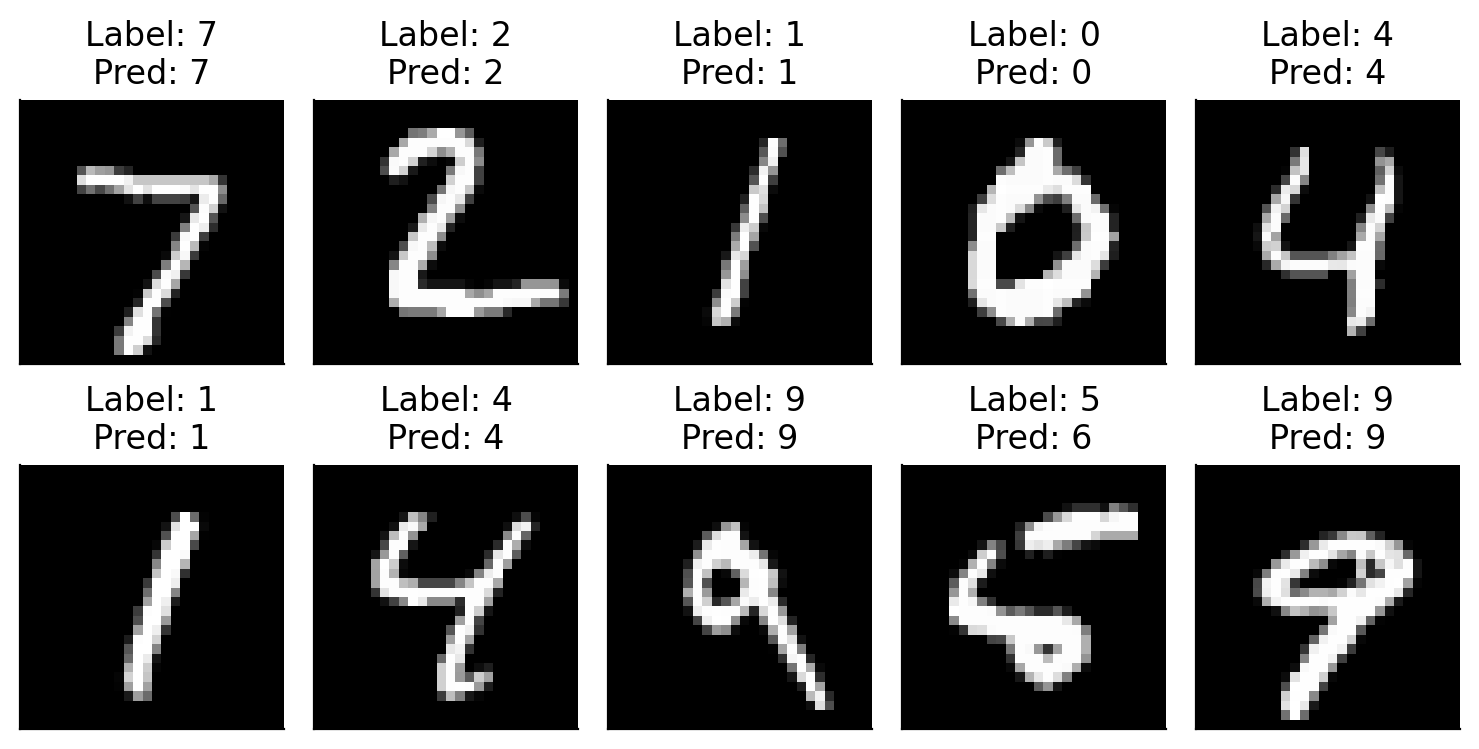

In [46]:
plot_examples(
    test_images[:10],
    labels=test_labels[:10],
    predictions=[
        predict(normalize(image, 0, 1).flatten(), weights, bias_size=1)
        for image in test_images[:10]
    ],
)